In [1]:
# 导入数据
# 数据预处理
# 构建G和D网络
# 建立训练过程
# 训练
# 保存模型
# 测试

In [2]:
import tensorflow as tf 

In [3]:
# 导入相关包
import numpy as np  
from tensorflow.keras import layers

In [4]:
# 测试GPU 是否可用
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# 导入数据
(train_imgs,train_labels),(test_imgs,test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
train_imgs.shape

(60000, 28, 28)

In [7]:
# 增加维度
train_imgs= np.asarray(train_imgs)
# print(train_imgs)
train_imgs = np.expand_dims(train_imgs, axis=-1) #数组的最后一个轴之后插入一个新的轴。

In [8]:
train_imgs.shape

(60000, 28, 28, 1)

In [9]:
# 像素值调整到【-1，1】
train_imgs = (train_imgs - 127.5) / 127.5

In [10]:
train_imgs.max()

1.0

In [11]:
train_imgs.min()

-1.0

In [12]:
# 构建dataset
BATCH_SIZE = 128
train_imgs = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(60000).batch(BATCH_SIZE)

In [13]:
train_imgs

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float64>

In [14]:
# 从dataset获取一张图

In [15]:
import matplotlib.pyplot as plt

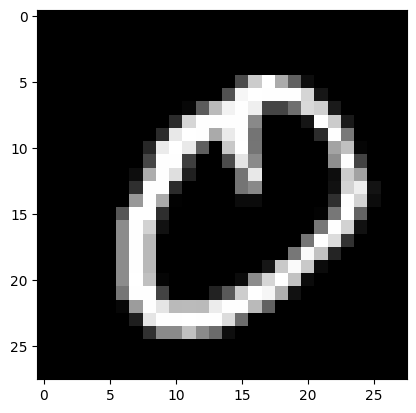

In [16]:
for img in train_imgs:
    plt.imshow(img[0],cmap='gray')
    break

# 显示网络架构
![](../GAN_theory/GAN/data/model_arc.png)

In [24]:
# 构建创作者G网络
G_model = tf.keras.Sequential([
    # input : 100 v
    # output : 7 * 7 *256 v
    layers.Dense(7*7*256,use_bias=False,input_shape=(100,)),
    # BN
    layers.BatchNormalization(),
    # ReLU
    layers.LeakyReLU(),
    # reshape 
    layers.Reshape((7,7,256)),

    # 上采样
    # input: 7x7x256
    # output:7x7x128
    layers.Conv2DTranspose(128,5,1,use_bias=False,padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # 上采样
    # input 7x7x128
    # output:14x14x64
    layers.Conv2DTranspose(64,5,2,use_bias=False,padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # 上采样
    # input：14x14x64
    # output:28x28x1
    layers.Conv2DTranspose(1,5,2,use_bias=False,padding='same',activation='tanh')
    
])

In [25]:
G_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

In [26]:
# 随机产生噪声向量，输入G，测试效果

In [27]:
noise_v = tf.random.normal((1,100))

In [28]:
noise_v

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.2457688 , -0.5816169 ,  1.2012948 ,  1.0483313 ,  0.92206746,
        -0.3890281 , -2.3143392 ,  0.33100316, -0.31407762, -0.2486758 ,
         0.9944975 , -1.2228624 ,  0.44405794, -0.09898974,  0.07404668,
         1.1343209 ,  0.31190524,  1.1542001 ,  0.5856179 ,  0.3370041 ,
         1.2437135 , -0.98404104, -0.01881699, -1.6715076 ,  0.36059353,
        -1.1249204 ,  0.3510992 ,  0.5252868 , -1.4903338 ,  0.9930521 ,
         0.7630403 , -1.5492738 , -0.46955588,  0.18623476, -0.7657533 ,
         0.27317402,  0.5223553 , -0.17078891,  1.1256814 ,  0.7090721 ,
         0.47203785, -0.40961277, -0.802362  , -0.6064784 , -1.4466217 ,
        -0.40213823,  0.65192765, -0.41917005, -0.7531328 ,  0.32147568,
         1.7893107 ,  0.8914519 , -1.8664283 , -0.6778389 , -0.94576365,
         0.708732  , -0.18701261,  0.10390481, -0.01544159, -0.46243986,
         0.18677096,  1.1600591 , -1.4929873 ,  0.33760694,  0.28318498,
 

In [29]:
generated_img = G_model(noise_v,training=False)

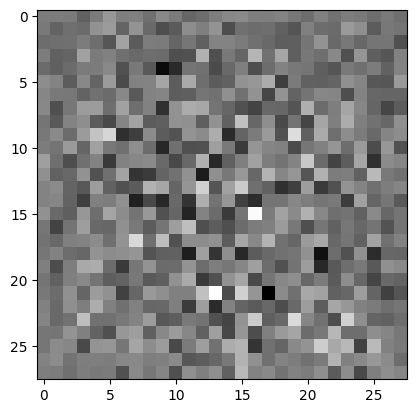

In [30]:
plt.imshow(generated_img[0]*127.5 + 127.5,cmap='gray')

# 显示网络架构
![](../GAN_theory/GAN/data/model_arc.png)

In [32]:
# 构建判别网络D
D_model = tf.keras.Sequential([
    # input :28x28x1
    # output: 14x14x64
    layers.Conv2D(64,5,2,padding='same',input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128,5,2,padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # 拉直，拼接
    layers.Flatten(),
    # input:6272
    # output:1
    layers.Dense(1)
])

In [33]:
D_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [34]:
# 将G生成得图片输入D
output = D_model(generated_img,training=False)

In [35]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00028245]], dtype=float32)>

In [37]:
# 定义损失函数和优化器
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)# 二元交叉熵
G_optimizer = tf.keras.optimizers.Adam(0.0001)
D_optimizer = tf.keras.optimizers.Adam(0.0001)

In [38]:
# 定义训练步骤
# 训练判别网络
    # 真实图片识别为1
    # 伪造图片识别为0
# 训练生成网络
    # 伪造图片，使得判别网络识别为1

In [39]:
@tf.function
def train_step(imgs):
    # 训练判别网络 真实图片识别为1
    with tf.GradientTape() as tape:
        # 真实图片得判别输出
        real_output = D_model(imgs,training=True)
        # 构造全1 样本
        ones_label = tf.ones_like(real_output)
        # 计算loss
        d_loss = cross_entropy(ones_label,real_output)
    # 计算梯度
    d_gradient = tape.gradient(d_loss,D_model.trainable_variables)
    # 优化器优化
    D_optimizer.apply_gradients(zip(d_gradient,D_model.trainable_variables))


    # 伪造图片识别为0
    with tf.GradientTape() as tape:
        # 伪造图片
        # 构建一个随机噪声向量
        noise_vector = tf.random.normal((BATCH_SIZE,100))
        # 生成的图片
        fake_img = G_model(noise_vector,training=True)
        # 伪造图片得判别输出
        fake_output = D_model(fake_img,training=True)
        # 构建全0样本
        zeros_label = tf.zeros_like(fake_output)
        # 计算loss
        d_loss = cross_entropy(zeros_label,fake_output)

    # 计算梯度
    d_gradient = tape.gradient(d_loss,D_model.trainable_variables)
    # 优化器优化
    D_optimizer.apply_gradients(zip(d_gradient,D_model.trainable_variables))


    # 训练生成网络
    with tf.GradientTape() as tape:
         # 构建一个随机噪声向量
        noise_vector = tf.random.normal((BATCH_SIZE,100))
        # 生成的图片
        fake_img = G_model(noise_vector,training=True)
        # 伪造图片得判别输出
        fake_output = D_model(fake_img,training=True)
        # 构建全0样本
        ones_label = tf.ones_like(fake_output)
        # 计算loss
        g_loss = cross_entropy(ones_label,fake_output)

    # 计算梯度
    g_gradient = tape.gradient(g_loss,G_model.trainable_variables)
    # 优化器优化
    G_optimizer.apply_gradients(zip(g_gradient,G_model.trainable_variables))
        
    
        

第1个epoch执行完毕,耗时：34.3443648815155s，将显示当前G网络生成图片


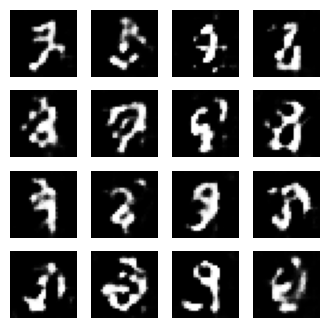

第2个epoch执行完毕,耗时：34.372650384902954s，将显示当前G网络生成图片


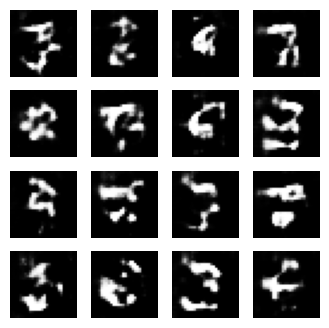

第3个epoch执行完毕,耗时：34.30757117271423s，将显示当前G网络生成图片


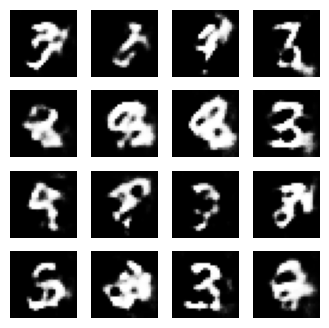

第4个epoch执行完毕,耗时：34.40827918052673s，将显示当前G网络生成图片


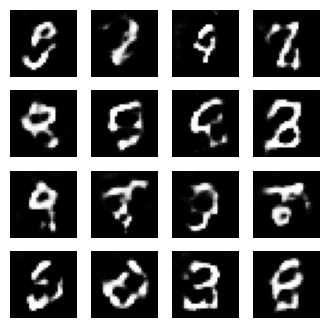

KeyboardInterrupt: 

In [42]:
# 开始训练
import time
test_noise = tf.random.normal((16,100))
epoch_num = 100
for epoch in range(epoch_num):
    # 获取批次图片128张
    start_time = time.time()
    for img_batch in train_imgs:
        # 训练
        train_step(img_batch)
        
    print('第{}个epoch执行完毕,耗时：{}s，将显示当前G网络生成图片'.format(epoch+1,time.time()-start_time))

    # 测试当前网络输出得图片
    generated_img = G_model(test_noise,training=False)
    # 显示16张图片
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(generated_img[i]*127.5+127.5,cmap='gray')
        plt.axis('off')
    plt.show()